<a href="https://colab.research.google.com/github/Ravimk07/Tensorflow_colab_examples/blob/master/Test2b_segmentation_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import h5py
import numpy as np
from PIL import Image
from matplotlib import  pyplot as plt
%matplotlib inline  

# Check the current drive location

In [0]:
# load the data by uploding on drive
os.getcwd()

'/content'

In [0]:
!rm -rf data(1).zip

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `rm -rf data(1).zip'


# Upload the database on drive

In [0]:
from google.colab import files
uploaded = files.upload()

Saving data1.zip to data1.zip


# Save the images on drive

In [0]:
for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    print('Saved file', name)

Saved file data1.zip


In [0]:
os.listdir('/content/')

['.config', 'data.zip', 'sample_data']

# Extracting the zip files to this current location

In [0]:

# This is for extracting the files
import zipfile
path_to_zip_file = 'data1.zip'
directory_to_extract_to = ''
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall(directory_to_extract_to)
zip_ref.close()

In [0]:
os.listdir('/content/')

['.config', 'data (1).zip', 'data1.zip', 'data', 'data1', 'sample_data']

# Check all the images with gt

In [0]:

os.listdir('/content/data1')

['image', 'gt']

In [0]:
original_imgs_train = "/content/data1/image" 
groundTruth_imgs_train = "/content/data1/gt" 

In [0]:
height = 864
width = 896

imgs_dir = original_imgs_train + "/2.jpg"
#imgs_dir = groundTruth_imgs_train + "/2_label.png"

img = Image.open(imgs_dir)
img_arr = np.asarray(img)

(1906, 896)


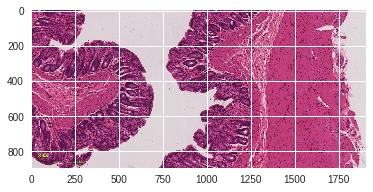

In [0]:
print(img.size)
plt.imshow(img)

(896, 1906, 3)
uint8


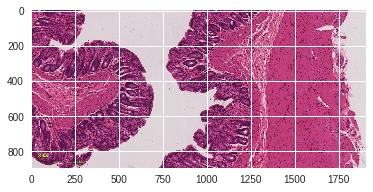

In [0]:
print(img_arr.shape)
print(img_arr.dtype)
plt.imshow(img_arr)

In [0]:
# Load data from directory
import numpy as np
import os
from PIL import Image
Nimgs = 3
channels = 3
height, width = 896,1906 

imgs_dir =  "/content/data1/image"
groundTruth_dir = "/content/data1/gt"
imgs = np.empty((Nimgs,height,width,channels))
groundTruth = np.empty((Nimgs,height,width))#,4))

# TODO: Cut image into 864, 1872
for path, subdirs, files in os.walk(imgs_dir): #list all files, directories in the path
        for i in range(len(files)):
            #img
            print("original image: " + files[i])
            img = Image.open(os.path.join(imgs_dir,files[i]))
            imgs[i] = np.asarray(img)
            #gt
            groundTruth_name = files[i][0:1] + "_label.png"
            print("ground truth name: " + groundTruth_name)
            g_truth = Image.open(os.path.join(groundTruth_dir, groundTruth_name))
            g_truth = g_truth.convert('L')
            g_truth = np.asarray(g_truth)
            unique = np.unique(g_truth.reshape(-1, 1), axis=0)
            np.putmask(g_truth, g_truth==unique[0], 0.0)
            np.putmask(g_truth, g_truth==unique[1], 1.0)
            np.putmask(g_truth, g_truth==unique[2], 2.0)
            np.putmask(g_truth, g_truth==unique[3], 3.0)
            groundTruth[i] = g_truth

imgs=imgs.astype('uint8')
groundTruth=groundTruth.astype('uint8')

original image: 3.jpg
ground truth name: 3_label.png
original image: 2.jpg
ground truth name: 2_label.png


(3, 896, 1906, 3)


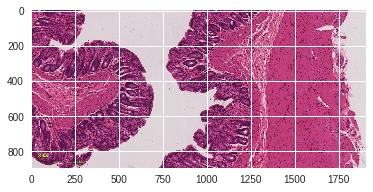

In [0]:
i=1
print(imgs.shape)
plt.imshow(imgs[i])

(3, 896, 1906)


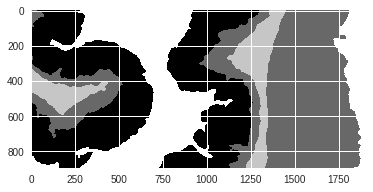

In [0]:
print(groundTruth.shape)
plt.imshow(groundTruth[i])

In [0]:
# Nimgs,height,width,channels
imgs = imgs[:,0:864,0:1872]  #cut bottom and top so now it is 565*565
groundTruth = groundTruth[:,0:864,0:1872] 

(3, 864, 1872, 3)


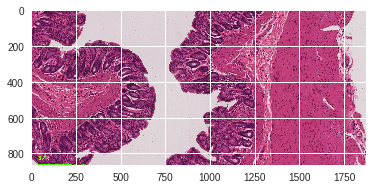

In [0]:
print(imgs.shape)
plt.imshow(imgs[i])

(3, 864, 1872)


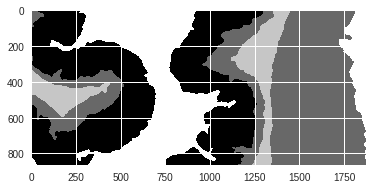

In [0]:
print(groundTruth.shape)
plt.imshow(groundTruth[i])

#plt.subplot(111)
#plt.imshow(groundTruth[1])

In [0]:
# Source: https://gist.github.com/dwf/366247
import os
import numpy as np
import scipy.ndimage as ndimage
import matplotlib
import matplotlib.pyplot as plt

def frac_eq_to(image, value=0):
    return (image == value).sum() / float(np.prod(image.shape))

def extract_patches(image, groundtruth, patchshape, overlap_allowed=0.5, cropvalue=None,
                    crop_fraction_allowed=0.1):
    """
    Given an image (grountruth), extract patches of a given shape with a certain
    amount of allowed overlap between patches, using a heuristic to
    ensure maximum coverage.

    If cropvalue is specified, it is treated as a flag denoting a pixel
    that has been cropped. Patch will be rejected if it has more than
    crop_fraction_allowed * prod(patchshape) pixels equal to cropvalue.
    Likewise, patches will be rejected for having more overlap_allowed
    fraction of their pixels contained in a patch already selected.
    """
    jump_cols = int(patchshape[1] * overlap_allowed)
    jump_rows = int(patchshape[0] * overlap_allowed)
    
    # Restrict ourselves to the rectangle containing non-cropped pixels
    #if cropvalue is not None:
        # TODO: cropvalue is the preferred class to be extracted i.e. 0,1,2,3
        # rows, cols = np.where(image != cropvalue)
        # TODO: use rows, and cols to guide extraction
    rows, cols = np.where(groundtruth == cropvalue)
        #rows.sort(); cols.sort()
        #active =  image[rows[0]:rows[-1], cols[0]:cols[-1]]
    #else:
    active_img = image
    active_gt = groundtruth

    rowstart = 0; colstart = 0

    # Array tracking where we've already taken patches.
    covered = np.zeros(active_gt.shape, dtype=bool)
    patches_imgs = []
    patches_gt = []

    while rowstart < active_gt.shape[0] - patchshape[0]:
        # Record whether or not e've found a patch in this row, 
        # so we know whether to skip ahead.
        got_a_patch_this_row = False
        colstart = 0
        while colstart < active_gt.shape[1] - patchshape[1]:
            # Slice tuple indexing the region of our proposed patch
            region = (slice(rowstart, rowstart + patchshape[0]),
                      slice(colstart, colstart + patchshape[1]))
            
            # The actual pixels in that region.
            patch = active_gt[region]

            # The current mask value for that region.
            cover_p = covered[region]
            if cropvalue is None or \
               frac_eq_to(patch, cropvalue) <= crop_fraction_allowed and \
               frac_eq_to(cover_p, True) <= overlap_allowed:
                # Accept the patch.
                patches_imgs.append(active_img[region])
                patches_gt.append(active_gt[region])
                
                # Mask the area.
                # TODO: Return convered
                covered[region] = True
                
                # Jump ahead in the x direction.
                colstart += jump_cols
                got_a_patch_this_row = True
                #print "Got a patch at %d, %d" % (rowstart, colstart)
            else:
                # Otherwise, shift window across by one pixel.
                colstart += 1

        if got_a_patch_this_row:
            # Jump ahead in the y direction.
            rowstart += jump_rows
        else:
            # Otherwise, shift the window down by one pixel.
            rowstart += 1

    # Return a 3D array of the patches with the patch index as the first
    # dimension (so that patch pixels stay contiguous in memory, in a 
    # C-ordered array).
    return (np.concatenate([pat[np.newaxis, ...] for pat in patches_imgs], axis=0), np.concatenate([pat[np.newaxis, ...] for pat in patches_gt], axis=0),covered)
#     return (patches_imgs,patches_gt,covered)

def plot_patches(patches, fignum=None, low=0, high=0):
    """
    Given a stack of 2D patches indexed by the first dimension, plot the
    patches in subplots. 

    'low' and 'high' are optional arguments to control which patches
    actually get plotted. 'fignum' chooses the figure to plot in.
    """
    try:
        istate = plt.isinteractive()
        plt.ioff()
        if fignum is None:
            fig = plt.gcf()
        else:
            fig = plt.figure(fignum)
        if high == 0:
            high = len(patches)
        pmin, pmax = patches.min(), patches.max()
        dims = np.ceil(np.sqrt(high - low))
        for idx in range(high - low):
            spl = plt.subplot(dims, dims, idx + 1)
            ax = plt.axis('off')
            im = plt.imshow(patches[idx], cmap=matplotlib.cm.gray)
            cl = plt.clim(pmin, pmax)
        plt.show()
    finally:
        plt.interactive(istate)

def filter_patches(patches, min_mean=0.0, min_std=0.0):
    """
    Filter patches by some criterion on their mean and variance.
    
    Takes patches, a 3-dimensional stack of image patches (where
    the first dimension indexes the patch), and a minimum
    mean and standard deviation. Returns a stack of all the 
    patches that satisfy both of these criteria.
    """
    patchdim = np.prod(patches.shape[1:])
    patchvectors = patches.reshape(patches.shape[0], patchdim)
    means = patchvectors.mean(axis=1)
    stdevs = patchvectors.std(axis=1)
    indices = (means > min_mean) & (stdevs > min_std)
    return patches[indices]

def extract_patches_from_dir(directory, patchsize, 
                             smoothing=None, overlap_allowed=0.5,
                             cropvalue=None, crop_fraction_allowed=0.1,
                             min_mean=0, min_std=0):
    """
    Extract patches from an entire directory of images.
    
    If `smoothing` is not None, it is used as the standard deviation of a
    Gaussian filter applied to the image before extracting patches.
    
    `patchsize`, `overlap_allowed`, `cropvalue` and `crop_fraction_allowed`
    are passed along to `extract_patches()`. `min_mean` and `min_std` are
    passed along to `filter_patches()`.
    """
    output = {}
    for fname in os.listdir(directory):
        if fname[-4:] == '.png':
            outname = fname.replace('.','_').replace('-','_')
            assert outname not in output
            image = plt.imread(os.path.join(directory, fname))
            if smoothing is not None:
                image = ndimage.gaussian_filter(image, smoothing)
            # Extract patches from the image.
            output[outname] = extract_patches(image, patchsize,
                                              overlap_allowed,
                                              cropvalue, crop_fraction_allowed)

            # Filter the patches that don't meet our standards.
            output[outname] = filter_patches(output[outname], min_std=min_std,
                                             min_mean=min_mean)
    return output

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
# Extract 
patchsize=48,48
overlap_allowed=0.6
cropvalue=[0,1,2,3]
crop_fraction_allowed=0.10

patches_imgs_train = np.empty((0,48,48,3))
patches_masks_train = np.empty((0,48,48))  # each pixel value could be either 0,1,2,3
    
for i in range(imgs.shape[0]-1): #  train on image 0 and 1
    for j in range(4): # 4 classes
        p_imgs,p_gt,covered = extract_patches(imgs[i], groundTruth[i], patchsize,
                                              overlap_allowed,
                                              cropvalue[j], crop_fraction_allowed)
        print('p_imgs.shape: ', p_imgs.shape)
        patches_imgs_train = np.append(patches_imgs_train,p_imgs,axis=0)
        patches_masks_train = np.append(patches_masks_train,p_gt,axis=0)

patches_imgs_train=patches_imgs_train.astype('uint8')
patches_masks_train=patches_masks_train.astype('uint8')

p_imgs.shape:  (1221, 48, 48, 3)
p_imgs.shape:  (1446, 48, 48, 3)
p_imgs.shape:  (944, 48, 48, 3)
p_imgs.shape:  (1166, 48, 48, 3)
p_imgs.shape:  (1237, 48, 48, 3)
p_imgs.shape:  (1504, 48, 48, 3)
p_imgs.shape:  (1017, 48, 48, 3)
p_imgs.shape:  (1007, 48, 48, 3)


(9542, 48, 48, 3)


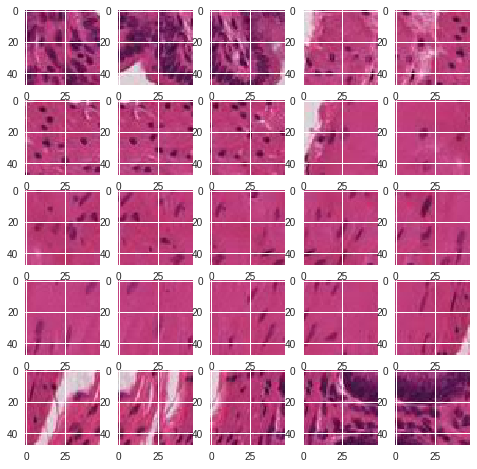

In [0]:
# Plot patches_imgs_train
print(patches_imgs_train.shape)
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
j=50
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(patches_imgs_train[i+j])
plt.show()

(9542, 48, 48)


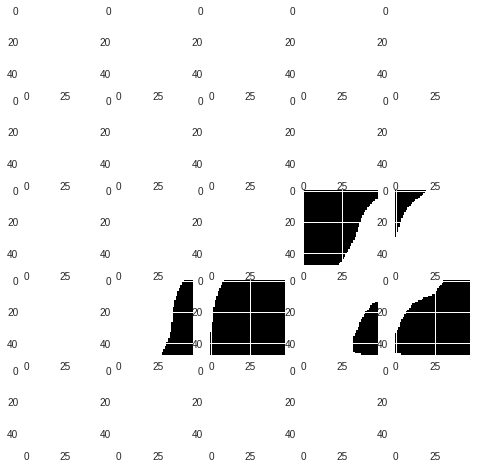

In [0]:
# Plot patches_masks_train
print(patches_masks_train.shape)
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
j=200
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(patches_masks_train[i+j])
plt.show()

In [0]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [0]:
import numpy as np

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD

# import sys
# sys.path.insert(0, './lib/')
# from help_functions import *
n_classes = 4

#Define the neural network
def get_unet(n_ch,patch_height,patch_width):
    inputs = Input(shape=(n_ch,patch_height,patch_width))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1],axis=1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2], axis=1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    #
    conv6 = Conv2D(n_classes, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    conv6 = core.Reshape((n_classes,patch_height*patch_width))(conv6)
    conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(input=inputs, output=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

    return model

Using TensorFlow backend.


In [0]:
#training settings
import os
N_epochs = 5
batch_size = 32
name_experiment = 'Segmentation_ravi_unet'

filename = './'+name_experiment+'/'+"sample_input_imgs"
if not os.path.exists(filename):
    os.makedirs(filename)
    
#========= Save a sample of what you're feeding to the neural network ==========
# N_sample = 5 #min(patches_imgs_train.shape[0],40)
# visualize(group_images(patches_imgs_train[0:N_sample,:,:,:],5),filename)#.show() # 
# visualize(group_images(patches_masks_train[0:N_sample,:,:,:],5),filename)#.show() # [0:N_sample,:,:,:]

#=========== Construct and save the model arcitecture =====
n_ch = 3#patches_imgs_train.shape[1]
patch_height = 48#patches_imgs_train.shape[2]
patch_width = 48#patches_imgs_train.shape[3]
model = get_unet(n_ch, patch_height, patch_width)  #the U-net model
print("Check: final output of the network:")
print(model.output_shape)
plot_model(model, to_file='./'+name_experiment+'/'+name_experiment + '_model.png',show_shapes=True)   #check how the model looks like
json_string = model.to_json()
open('./'+name_experiment+'/'+name_experiment +'_architecture.json', 'w').write(json_string)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


Check: final output of the network:
(None, 2304, 4)


10465

In [0]:
#prepare the mask in the right shape for the Unet
def masks_Unet(masks):
    assert (len(masks.shape)==4)  #4D arrays
    assert (masks.shape[1]==1 )  #check the channel is 1
    im_h = masks.shape[2]
    im_w = masks.shape[3]
    masks = np.reshape(masks,(masks.shape[0],im_h*im_w))
    new_masks = np.empty((masks.shape[0],im_h*im_w,4)) # original is 2
    for i in range(masks.shape[0]):
        for j in range(im_h*im_w):
            if  masks[i,j] == 0:
                new_masks[i,j,0]=1
                new_masks[i,j,1]=0
                new_masks[i,j,2]=0
                new_masks[i,j,3]=0
            elif masks[i,j] == 1:
                new_masks[i,j,0]=0
                new_masks[i,j,1]=1
                new_masks[i,j,2]=0
                new_masks[i,j,3]=0
            elif masks[i,j] == 2:
                new_masks[i,j,0]=0
                new_masks[i,j,1]=0
                new_masks[i,j,2]=1
                new_masks[i,j,3]=0
            elif masks[i,j] == 3:
                new_masks[i,j,0]=0
                new_masks[i,j,1]=0
                new_masks[i,j,2]=0
                new_masks[i,j,3]=1
    return new_masks

In [0]:
patches_imgs_train.shape, patches_masks_train.shape

((9542, 48, 48, 3), (9542, 48, 48))

In [0]:
np.moveaxis(patches_imgs_train,3,1).shape, np.expand_dims(patches_masks_train,axis=1).shape

((9542, 3, 48, 48), (9542, 1, 48, 48))

In [0]:
#============  Training ==================================
checkpointer = ModelCheckpoint(filepath='./'+name_experiment+'/'+name_experiment +'_best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased

# Channel first
patches_masks_train_flatten = masks_Unet(np.expand_dims(patches_masks_train,axis=1))  #reduce memory consumption
history = model.fit(np.moveaxis(patches_imgs_train,3,1), 
                    patches_masks_train_flatten, 
                    nb_epoch=N_epochs, 
                    batch_size=batch_size, 
                    verbose=2, shuffle=True, 
                    validation_split=0.1, 
                    callbacks=[checkpointer])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 8587 samples, validate on 955 samples
Epoch 1/5
 - 2417s - loss: 1.4083 - acc: 0.2299 - val_loss: 1.3863 - val_acc: 0.3048

Epoch 00001: val_loss improved from inf to 1.38629, saving model to ./Segmentation_ravi_unet/Segmentation_ravi_unet_best_weights.h5
Epoch 2/5
 - 2415s - loss: 1.3863 - acc: 0.2300 - val_loss: 1.3863 - val_acc: 0.3048

Epoch 00002: val_loss did not improve from 1.38629
Epoch 3/5
 - 2412s - loss: 1.3863 - acc: 0.2300 - val_loss: 1.3863 - val_acc: 0.3048

Epoch 00003: val_loss did not improve from 1.38629
Epoch 4/5
 - 2412s - loss: 1.3863 - acc: 0.2300 - val_loss: 1.3863 - val_acc: 0.3048

Epoch 00004: val_loss did not improve from 1.38629
Epoch 5/5


#  Getting and resizing images with ground truth labelled

In [0]:
def get_data(path, train=True):
    ids = glob.glob(os.path.join(path, "images", '*.jpg'))
    ids = [os.path.basename(i)[:-4] for i in ids] 
    X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        x_img = imread(os.path.join(path, 'images', id_ + '.jpg'))
        #x_img = img.pixel_array
        x_img = resize(x_img, (256, 256, 3), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(os.path.join(path, 'gt', id_ + '.png'), grayscale=True))
            mask = resize(mask, (256, 256, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., :] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)

Getting and resizing images ... 


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done!


In [0]:
from keras.models import Input, Model
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization

# Define model

In [0]:
def conv_block(model, dim, activation = 'relu', batch_norm = 'True', residual = 'True', drate = 0.5):
	n = Conv2D(dim, 3, activation = activation, padding='same', kernel_initializer = 'he_normal')(model)
	n = BatchNormalization()(n) if batch_norm else n
	n = Dropout(drate)(n) if drate else n
	n = Conv2D(dim, 3, activation = activation, padding='same', kernel_initializer = 'he_normal')(n)
	n = BatchNormalization()(n) if batch_norm else n
	return Concatenate()([model, n]) if residual else n

def level_block(model, dim, depth, inc, acti, drate, batch_norm, maxpool, upconv, residual):
	if depth > 0:
		n = conv_block(model, dim, acti, batch_norm, residual)
		model = MaxPooling2D()(n) if maxpool else Conv2D(dim, 3, strides=2, padding='same')(n)
		model = level_block(model, int(inc*dim), depth-1, inc, acti, drate, batch_norm, maxpool, upconv, residual)
		if upconv:
			model = UpSampling2D()(model)
			model = Conv2D(dim, 2, activation=acti, padding='same', kernel_initializer = 'he_normal')(model)
		else:
			model = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same', kernel_initializer = 'he_normal')(model)
		n = Concatenate()([n, model])
		model = conv_block(n, dim, acti, batch_norm, residual)
	else:
		model = conv_block(model, dim, acti, batch_norm, residual, drate)
	return model

def UNet(img_shape, out_ch = 1, start_ch = 64, depth = 4, inc_rate = 2, activation = 'relu', 
		 dropout = 0.5, batchnorm = True, maxpool = True, upconv = True, residual = True):
	i = Input(shape = img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

model = UNet((256, 256, 3), out_ch = 1, start_ch = 64, depth = 5, inc_rate = 2, activation = 'relu',
             dropout = 0.5, batchnorm = True, maxpool = True, upconv = True, residual = True)

# Split the images into training and testing

In [0]:
import gc
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=2019)
del(X)
del(y)
gc.collect()

14

In [0]:
print(X_train.shape)
print(X_valid.shape)

(791, 256, 256, 3)
(340, 256, 256, 3)


# Compile the model

In [0]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy', dice_coef_loss])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
from keras.callbacks import TensorBoard

callbacks = [
    #EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/ravi_model-tgs-salt-dropout0.5-diceloss.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir='/content/logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=True)
]

# Train the model

In [0]:
results = model.fit(X_train, y_train, batch_size=2, epochs=10, callbacks=callbacks, shuffle = True,
                   validation_data=(X_valid, y_valid))

Train on 791 samples, validate on 340 samples
Epoch 1/10
791/791 [==============================] - 566s 715ms/step - loss: 0.5567 - acc: 0.0000e+00 - dice_coef_loss: 0.0217 - val_loss: 0.4821 - val_acc: 0.0000e+00 - val_dice_coef_loss: 0.0104

Epoch 00001: val_loss improved from inf to 0.48211, saving model to /content/ravi_model-tgs-salt-dropout0.5-diceloss.h5
Epoch 2/10
791/791 [==============================] - 545s 690ms/step - loss: 0.4749 - acc: 0.0000e+00 - dice_coef_loss: 0.0086 - val_loss: 0.4708 - val_acc: 0.0000e+00 - val_dice_coef_loss: 0.0081

Epoch 00002: val_loss improved from 0.48211 to 0.47080, saving model to /content/ravi_model-tgs-salt-dropout0.5-diceloss.h5
Epoch 3/10
791/791 [==============================] - 546s 690ms/step - loss: 0.4662 - acc: 0.0000e+00 - dice_coef_loss: 0.0067 - val_loss: 0.4600 - val_acc: 0.0000e+00 - val_dice_coef_loss: 0.0057

Epoch 00003: val_loss improved from 0.47080 to 0.46004, saving model to /content/ravi_model-tgs-salt-dropout0.5-d

# Check the predicted patch  output image

Text(0.5,0,'Predicted patch')

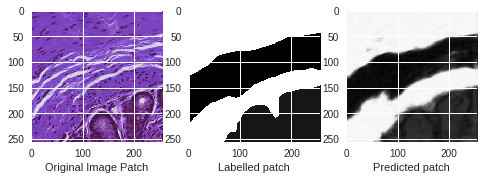

In [0]:
temp = model.predict(X_valid[33].reshape((1, 256, 256, 3)))

plt.subplot(131)
plt.imshow(X_valid[33].reshape((256, 256,3)))
plt.xlabel('Original Image Patch')
plt.subplot(132)
plt.imshow(y_valid[33].reshape((256, 256)))
plt.xlabel('Labelled patch')
plt.subplot(133)
plt.imshow(temp.reshape((256, 256)))
plt.xlabel('Predicted patch')

In [0]:
from skimage.io import imsave
imsave('/content/newer_results.png', temp.reshape((256, 256)))
imsave('/content/newer_gt.png', X_valid[33].reshape((256, 256,3)))
imsave('/content/newer_image.png', y_valid[33].reshape((256, 256)))

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [0]:
import cv2
image = r"/content/2.jpg"
gt = r"/content/"

original_image = imread(image)


# Segmented output of whole image

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


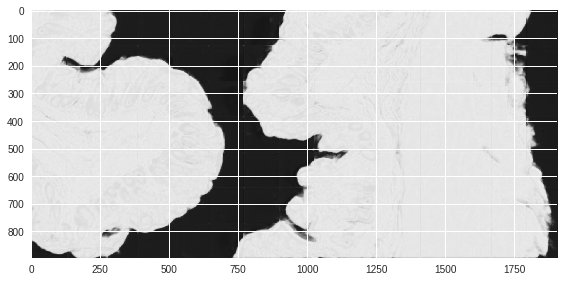

In [0]:
soln = np.zeros([1024, 2048])
original_image = np.pad(original_image, ((0, 128), (0, 142), (0, 0)), 'constant', constant_values = 225)
#gt_image = np.pad(gt_image, ((0, 128), (0, 142)), 'constant', constant_values = 24)
for i in range(0, 769, 128):
    for j in range(0, 1793, 128):
        temp_image = original_image[i: i+256, j: j+256]
        #temp_image /= 255
        temp_image = temp_image.squeeze() / 255
        soln[i: i+256, j: j+256] = model.predict(temp_image.reshape((1, 256, 256, 3))).reshape((256, 256))
        #soln = model.predict(temp_image.reshape((1, 256, 256, 3))).reshape((256, 256))
soln = soln[:896, :1906]
imshow(soln)

In [0]:
imsave('/content/Segmented_image_2.png', soln)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


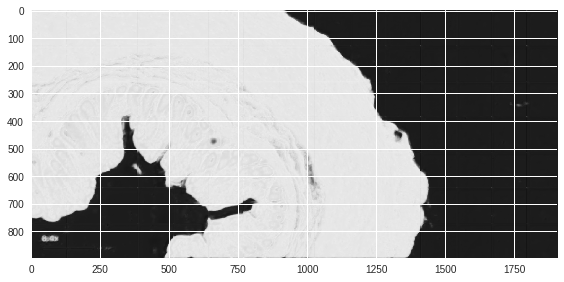

In [0]:
image = r"/content/1.jpg"
gt = r"/content/"

original_image = imread(image)

soln = np.zeros([1024, 2048])
original_image = np.pad(original_image, ((0, 128), (0, 142), (0, 0)), 'constant', constant_values = 225)
#gt_image = np.pad(gt_image, ((0, 128), (0, 142)), 'constant', constant_values = 24)
for i in range(0, 769, 128):
    for j in range(0, 1793, 128):
        temp_image = original_image[i: i+256, j: j+256]
        #temp_image /= 255
        temp_image = temp_image.squeeze() / 255
        soln[i: i+256, j: j+256] = model.predict(temp_image.reshape((1, 256, 256, 3))).reshape((256, 256))
        #soln = model.predict(temp_image.reshape((1, 256, 256, 3))).reshape((256, 256))
soln = soln[:896, :1906]
imshow(soln)
imsave('/content/output_image_1.png', soln)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


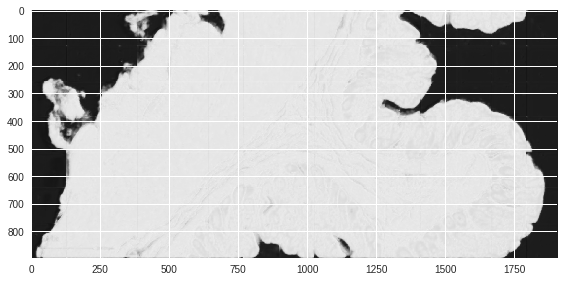

In [0]:
image = r"/content/3.jpg"
gt = r"/content/"

original_image = imread(image)

soln = np.zeros([1024, 2048])
original_image = np.pad(original_image, ((0, 128), (0, 142), (0, 0)), 'constant', constant_values = 225)
#gt_image = np.pad(gt_image, ((0, 128), (0, 142)), 'constant', constant_values = 24)
for i in range(0, 769, 128):
    for j in range(0, 1793, 128):
        temp_image = original_image[i: i+256, j: j+256]
        #temp_image /= 255
        temp_image = temp_image.squeeze() / 255
        soln[i: i+256, j: j+256] = model.predict(temp_image.reshape((1, 256, 256, 3))).reshape((256, 256))
        #soln = model.predict(temp_image.reshape((1, 256, 256, 3))).reshape((256, 256))
soln = soln[:896, :1906]
imshow(soln)
imsave('/content/Segmented_image_3.png', soln)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


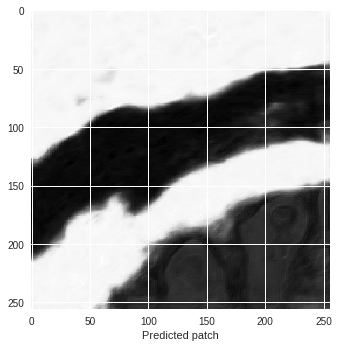

In [0]:
plt.subplot(111)
plt.imshow(temp.reshape((256, 256)))
plt.xlabel('Predicted patch')
imsave('/content/Predicted_patch.png', temp.reshape((256, 256)))